In [63]:
import re
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
# For reproduceability, consider setting seed, https://medium.com/@ODSC/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

In [65]:
prefix = '/home/shane/minerl/pdddqn/'

experiments = {
    'baseline': 'result/85a45807b34265153c1859459809b9d49691a674-2f630116-1ee07c14/',
#    'k_16': 'result/85a45807b34265153c1859459809b9d49691a674-653f3a8f-ea8043ef/',
#    'lr_0002': 'lr-0.0002/85a45807b34265153c1859459809b9d49691a674-653f3a8f-d16ce028/',
#    'lr_0002_long': 'lr-0.0002_long/85a45807b34265153c1859459809b9d49691a674-653f3a8f-bc8811fd/',
    'lr_000125_k16': 'result/85a45807b34265153c1859459809b9d49691a674-653f3a8f-9f5c89e5/',
#    'lr_000125_k20': 'lr-0.000125_k20/85a45807b34265153c1859459809b9d49691a674-653f3a8f-08eddedb/'
    
}

experiments = {k: prefix + v for k, v in experiments.items()}

In [66]:
rx_dict = {
    'statistics': re.compile(r"statistics:(?P<statistics>.*)\n"),
    'result': re.compile(r"outdir:.* (?P<result>step:(\d+) episode:(\d+) R:(.*))\n")
}
def _parse_line(line):
    for key, rx in rx_dict.items():
        match = rx.search(line)
        if match:
            #print(key)
            return key, match
    return None, None

In [67]:
# instead, join on episode. But, have to join the lines
train_losses = pd.DataFrame()
train_q_values = pd.DataFrame()
train_rewards = pd.DataFrame()

for name, path in experiments.items():
    statistics = []
    rewards = []
    
    # read the log file, parse the fields, create a statistics and rewards list
    with open(f"{path}log.txt", 'r') as f:
        for line in f:
            key, match = _parse_line(line)
            if key == 'statistics':
                # replace nan with 0
                stats = match.group('statistics').replace('nan', '0.0')
                # convert the list of tuples into a dict
                statistics.append(dict(eval(stats)))

            if key == 'result':
                result = match.group('result').replace('nan', '0.0').split()
                rewards.append(dict(map(lambda s : s.split(':'), result)))

        
        
        df = pd.DataFrame(rewards).apply(pd.to_numeric).set_index('episode')
        df = df.join(pd.DataFrame(statistics).set_index('cumulative_steps'), on='step')
        train_losses = pd.concat([train_losses, df['average_loss'].rename(name)], axis=1)
        train_q_values = pd.concat([train_q_values, df['average_q'].rename(name)], axis=1)
        train_rewards = pd.concat([train_rewards, df['R'].rename(name)], axis=1)

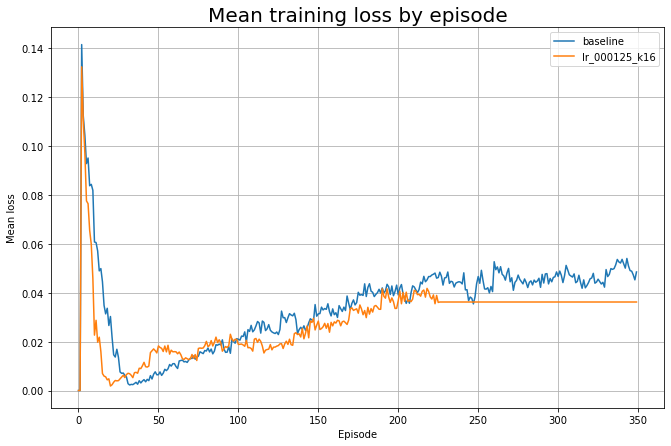

In [68]:
fig, ax = plt.subplots(figsize=(11,7))

train_losses[:350].interpolate().plot(ax=ax)

ax.set_title("Mean training loss by episode", fontsize=20)
ax.set_xlabel('Episode')
ax.set_ylabel('Mean loss')
ax.grid()

<AxesSubplot:>

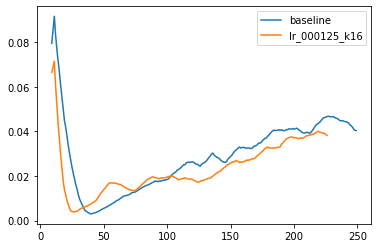

In [69]:
train_losses[:250].rolling(10).mean().plot()

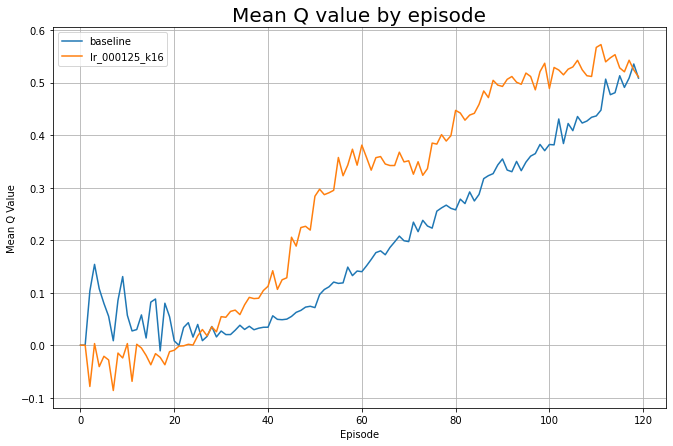

In [70]:
fig, ax = plt.subplots(figsize=(11,7))

train_q_values[:120].interpolate().plot(ax=ax)

ax.set_title("Mean Q value by episode", fontsize=20)
ax.set_xlabel('Episode')
ax.set_ylabel('Mean Q Value')
ax.grid()


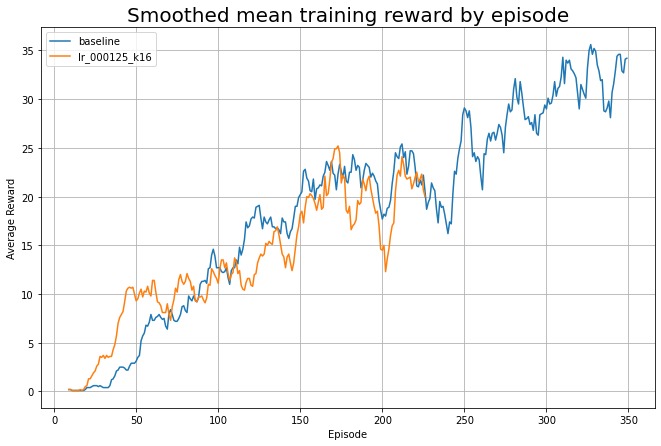

In [71]:
window = 10

fig, ax = plt.subplots(figsize=(11,7))

for name, series in train_rewards[:350].iteritems():
    mean = series.rolling(window).mean()
    sigma = series.rolling(window).std()
    ax.plot(mean, label=name)
    # comment out to remove standard deviation spread
    #ax.fill_between(series.index.tolist(), mean+sigma, mean-sigma, alpha=0.25)
    
ax.set_title("Smoothed mean training reward by episode", fontsize=20)
ax.legend(loc='upper left')
ax.set_xlabel('Episode')
ax.set_ylabel('Average Reward')
ax.grid()

In [72]:
eval_losses = pd.DataFrame()
eval_q_values = pd.DataFrame()
eval_rewards = pd.DataFrame()

for name, path in experiments.items():
    df = pd.read_csv(f"{path}scores.txt", sep="\t").set_index('episodes')
    eval_losses = pd.concat([eval_losses, df['average_loss'].rename(name)], axis=1)
    eval_q_values = pd.concat([eval_q_values, df['average_q'].rename(name)], axis=1)
    eval_rewards = pd.concat([eval_rewards, df['mean'].rename(name)], axis=1) 

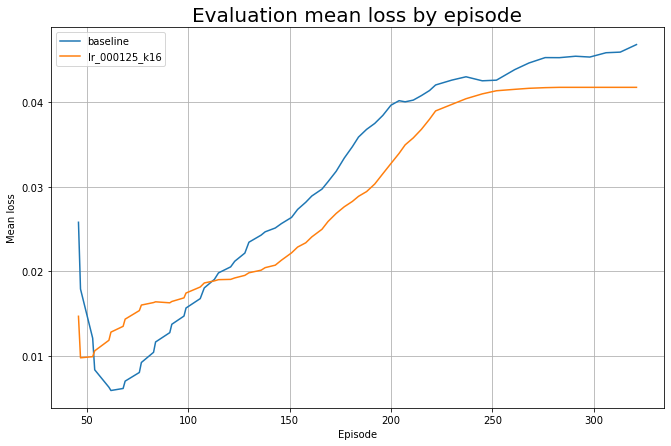

In [78]:
window = 10

fig, ax = plt.subplots(figsize=(11,7))

eval_losses[:70].interpolate().rolling(window).mean().plot(ax=ax)

ax.set_title("Evaluation mean loss by episode", fontsize=20)
ax.set_xlabel('Episode')
ax.set_ylabel('Mean loss')
ax.grid()

In [74]:
#eval_rewards[:60]
#eval_rewards[:60].rolling(10, min_periods=1).mean()

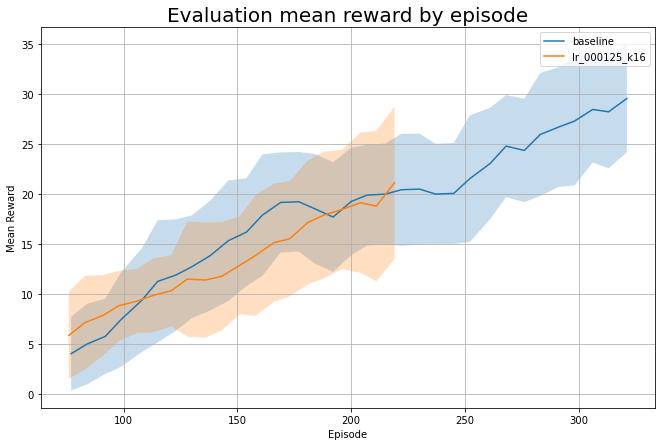

In [75]:
fig, ax = plt.subplots(figsize=(11,7))

# unsmoothed
#eval_rewards[:70].interpolate().plot(ax=ax)

# # smoothed versions
# window = 3
# eval_rewards[:30].rolling(window, min_periods=1).mean().plot(ax=ax)

window = 10
for name, series in eval_rewards[:70].iteritems():
    series = series[series.notna()]
    mean = series.rolling(window).mean()
    sigma = series.rolling(window).std()
    ax.plot(mean, label=name)
#     # comment out to remove standard deviation spread
    ax.fill_between(series.index.tolist(), mean+sigma, mean-sigma, alpha=0.25)
ax.legend()
ax.set_title("Evaluation mean reward by episode", fontsize=20)
ax.set_xlabel('Episode')
ax.set_ylabel('Mean Reward')
ax.grid()

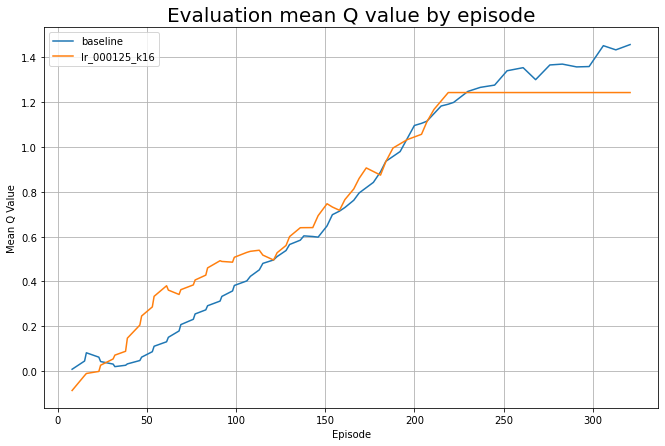

In [76]:
fig, ax = plt.subplots(figsize=(11,7))

eval_q_values[:70].interpolate().plot(ax=ax)

ax.set_title("Evaluation mean Q value by episode", fontsize=20)
ax.set_xlabel('Episode')
ax.set_ylabel('Mean Q Value')
ax.grid()

In [33]:
eval_rewards['lr_000125_k16'][eval_rewards['lr_000125_k16'].notna()]

8       1.333333
15      0.333333
23      1.666667
31      5.000000
38      9.333333
46      7.000000
53     13.000000
61     11.666667
68      5.000000
76      4.666667
83     14.000000
91      7.666667
98     11.333333
106     9.666667
113    15.000000
121    11.666667
128    24.666667
136    10.666667
143     8.666667
151    15.666667
158    24.000000
166    20.333333
173    15.333333
181    26.000000
188    22.333333
196    17.333333
204    31.333333
211     7.333333
219    32.000000
Name: lr_000125_k16, dtype: float64